In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import glob
objpoints = []
imgpoints = []
images = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


for img_name in images:
    img = mpimg.imread(img_name)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)



In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

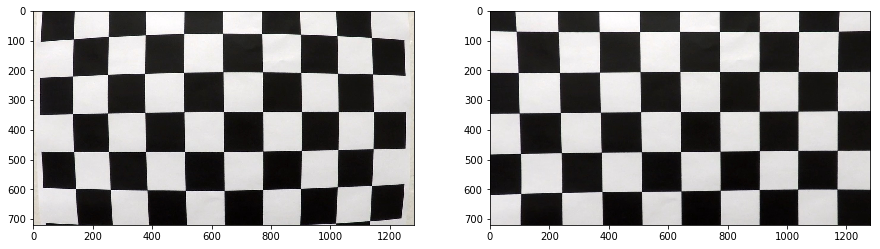

In [5]:
camera_img = mpimg.imread('./camera_cal/calibration1.jpg')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(1, 2, 1)
plt.imshow(camera_img)                          
plt.subplot(1, 2, 2)
plt.imshow(cv2.undistort(camera_img, mtx, dist, None, mtx))

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x' :
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx) 
    sxbinary = np.zeros_like(dir_sobel)
    sxbinary[(dir_sobel >= thresh[0]) & (dir_sobel<= thresh[1])] = 1
    return sxbinary

def HLS(image,s_thresh=(170, 255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    l_channel = hls[:,:,1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 120) & (l_channel <= 255)] = 1
   
    combined_result = np.zeros_like(s_channel)
    combined_result[((s_binary==1) & (l_binary==1))] = 1
    
    
    return combined_result

def Perspective(src,dest):
    return cv2.getPerspectiveTransform(src, dest)

def wraped(image,M):
    img_size = (image.shape[1],image.shape[0])
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

def threshold(image):
    ksize = 3
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize,thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.15))
    
    sxbinary = np.zeros_like(image[:,:,2])
    sxbinary[((gradx == 1) & (grady == 1)) | ((dir_binary == 1) & (mag_binary == 1))] = 1
    
    s_binary = HLS(image,s_thresh=(170, 255))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (s_binary == 1) | (sxbinary == 1)] = 1

    
    return combined_binary
    

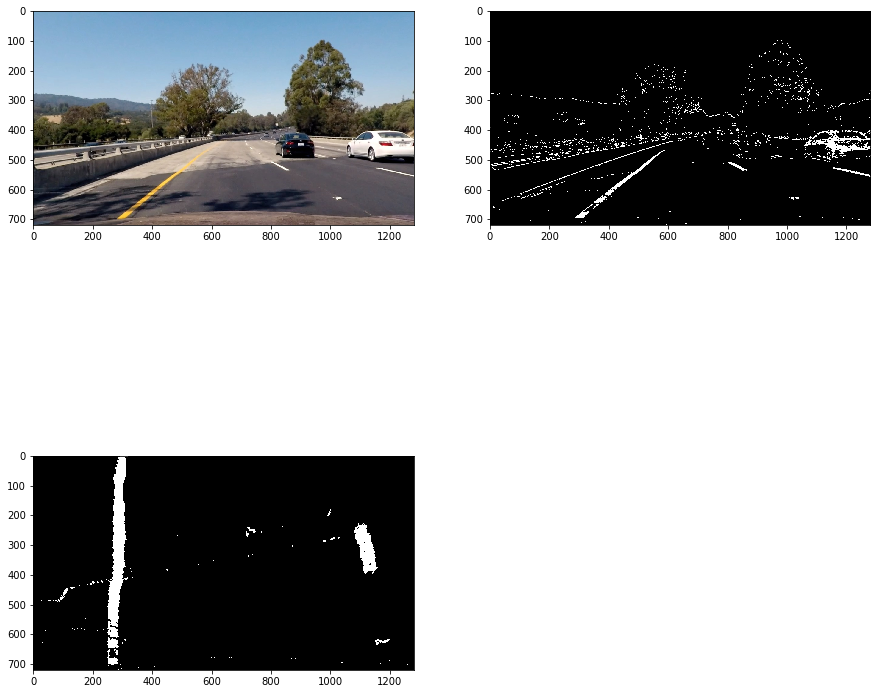

In [7]:
img = './test_images/test4.jpg'
img = mpimg.imread(img)
undst_img = cv2.undistort(img, mtx, dist, None, mtx)
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(2, 2, 1)
plt.imshow(undst_img)
thresholded_img = threshold(undst_img)
plt.subplot(2, 2, 2)
plt.imshow(thresholded_img,cmap = 'gray')
src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

M = Perspective(src,dst)

warped_img = wraped(thresholded_img,M)
plt.subplot(2, 2, 3)
plt.imshow(warped_img,cmap = 'gray')

In [8]:
def process_img(image):
    undst_img = cv2.undistort(image, mtx, dist, None, mtx)
    thresholded_img = threshold(undst_img)
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0],[1250, 720],[40, 720]])
    
 
    M = Perspective(src,dst)
    warped_img = wraped(thresholded_img,M)
    
    return warped_img

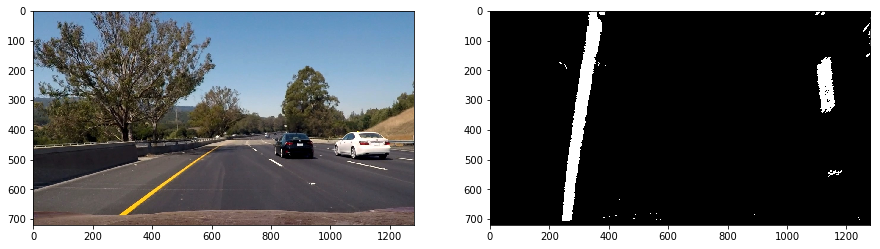

In [9]:
images = glob.glob('./test_images/test6.jpg')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
for img_name in images:
    plt.subplot(1, 2, 1)
    img_read = mpimg.imread(img_name)
    plt.imshow(img_read)
    plt.subplot(1, 2, 2)
    output_image = process_img(img_read)
    plt.imshow(output_image,cmap='gray')
    

In [10]:
def find_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx,lefty,rightx,righty,left_fit,right_fit,out_img

In [11]:
def find_lines_in_margin(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx,lefty,rightx,righty,left_fit,right_fit

In [12]:
def fill_poly(warped,left_fitx,ploty,right_fitx,Minv,image):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

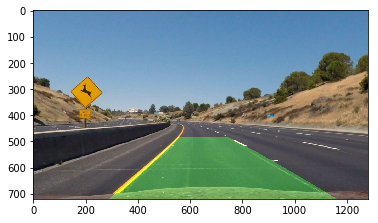

In [13]:
input_img = mpimg.imread('./test_images/test2.jpg')
undst_image = undst_img = cv2.undistort(input_img, mtx, dist, None, mtx)
binary_warped = process_img(input_img)


leftx,lefty,rightx,righty,left_fit,right_fit,out_img = find_lines(binary_warped)



ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0],[1250, 720],[40, 720]])


Minv = cv2.getPerspectiveTransform(dst,src)
result = fill_poly(binary_warped,left_fitx,ploty,right_fitx,Minv,undst_image)
plt.imshow(result)

In [16]:
def pipeline(image):
    global rightfitList, leftfitList
    list_len = 15
    undst_image = undst_img = cv2.undistort(image, mtx, dist, None, mtx)
    binary_warped = process_img(image)
    
    if(len(rightfitList) < list_len and len(leftfitList) < list_len):
        leftx,lefty,rightx,righty,left_fit,right_fit,out_img = find_lines(binary_warped)
    else:
        leftx,lefty,rightx,righty,left_fit,right_fit = find_lines_in_margin(binary_warped,np.mean(leftfitList,axis=0),np.mean(rightfitList,axis=0))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if(len(rightfitList) > (list_len-1) and len(leftfitList) > (list_len-1)):
        rightfitList = rightfitList[1:] 
        leftfitList = leftfitList[1:]
    
    rightfitList.append(right_fit)
    leftfitList.append(left_fit)   
        
        
    #src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0],[1250, 720],[40, 720]])
    
    Minv = cv2.getPerspectiveTransform(dst,src)
    result = fill_poly(binary_warped,left_fitx,ploty,right_fitx,Minv,undst_image)
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/925 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(np.array(lefty,dtype=np.float32)*ym_per_pix,np.array(leftx,dtype=np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty,dtype=np.float32)*ym_per_pix,np.array(rightx,dtype=np.float32)*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature :'+str(np.round(((left_curverad+right_curverad)/2),2)),(300,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    lane_center = (leftx[-1] + rightx[-1])/2
    car_position = result.shape[1]/2
    # Define conversions in x and y from pixels space to meters
    
    
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Center Offset : '+str(np.round((np.absolute(car_position - lane_center))*xm_per_pix ,2)),(350,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    
    return result
    
    

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
global rightfitList, leftfitList
rightfitList = []
leftfitList = []
write_output = 'project_video_out7.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out7.mp4
[MoviePy] Writing video project_video_out7.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:31<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out7.mp4 

Wall time: 11min 34s
